In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from keras.backend import tf as ktf
from keras.models import load_model
import PIL.Image as Image
from scipy.misc import imresize
from scipy import ndimage
from scipy.ndimage.measurements import label
from collections import deque


Using TensorFlow backend.


## Load The model

In [2]:
model = load_model('my_model.h5', custom_objects={"ktf": ktf})

## Create a deque.
Deque will be used to:
* Store responses
* Filter out false-positive by making averaging the response in the last 30 frams


In [3]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [4]:
previous = deque()
def process_image(image , heatmap=False):
    global previous
    rgb = image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab);
    
    data = image[np.newaxis,:,:,:]
    
    response = model.predict(data)

    response = response*255
    response = response.reshape((180,320))
    response = response.astype(np.uint8)
    response[0:100,:]=0 # Remove anything on the top half of the image (no cars on the sky!)
    previous.append(response)
    if len(previous) > 30:
        previous.popleft()
    
    if len(previous) ==1 :
        arr = response
    else:
        arr = np.array(previous)
        arr = arr.astype(np.uint8)
        arr = arr.mean(axis=0)
    
    #show heatmap
    if heatmap:
        return arr
    #Threshold Selection
    tr = arr >  10
    tr = tr.astype(np.uint8)*255
    kernel =  np.ones((3,3),dtype=np.uint8)
    mask = cv2.erode(tr, kernel  , iterations=8)
    mask = cv2.dilate(mask, kernel  , iterations=7)
    
    # Genrate RGB Image
    img= imresize(mask,(720,1280),interp='nearest')
    labels = label(img)
    result =draw_labeled_bboxes(rgb,labels)
    return result

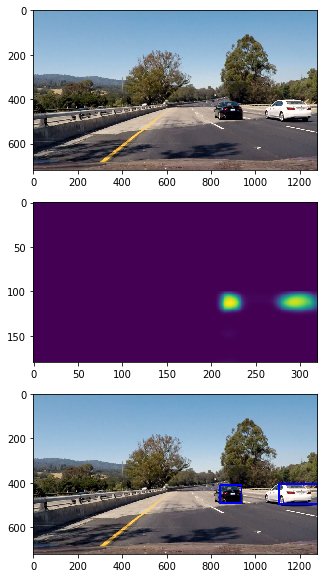

In [5]:
img =  np.array(Image.open('test_images/test4.jpg'))
fig,axs = plt.subplots(3,1, figsize=(10, 10))
axs[0].imshow(img)
axs[1].imshow(process_image(img,True))
axs[2].imshow(process_image(img))


In [6]:
result = process_image(img,True)


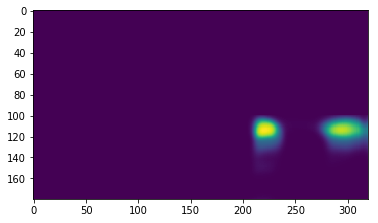

In [7]:
plt.imshow(result)

## Process Video

In [8]:
previous = deque()

In [9]:
from moviepy.editor import VideoFileClip

clip1 = VideoFileClip("./project_video.mp4")
wclip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time wclip.write_videofile('out.mp4', audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████▉| 1260/1261 [00:40<00:00, 31.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

CPU times: user 39.5 s, sys: 2.58 s, total: 42 s
Wall time: 40.8 s


In [10]:
import glob

In [11]:
images=[]

for fn in glob.iglob('test_images/test*.jpg'):
    images.append(cv2.cvtColor(np.array(Image.open(fn)), cv2.COLOR_RGB2Lab))
images = np.array(images)
pred

NameError: name 'pred' is not defined

In [ ]:
images